In [0]:
%config IPCompleter.greedy=True

In [2]:
%tensorflow_version 1.x
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

TensorFlow 1.x selected.
1.15.2
2.3.1


Using TensorFlow backend.


In [0]:
def reset_tf_session():
  curr_session=tf.get_default_session()
  if curr_session is not None:
    curr_session.close()
  K.clear_session()
  config=tf.ConfigProto()
  config.gpu_options.allow_growth=True
  s=tf.InteractiveSession(config=config)
  K.set_session(s)
  return s

In [0]:
from keras.datasets import cifar10
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [5]:
print('Train samples',x_train.shape,y_train.shape)
print('Test samples',x_test.shape,y_test.shape)

Train samples (50000, 32, 32, 3) (50000, 1)
Test samples (10000, 32, 32, 3) (10000, 1)


In [0]:
NUM_CLASSES=10
cifar10_classes=['airplane','automobile','bird','cat','deer',
                 'dog','frog','horse','ship','truck']

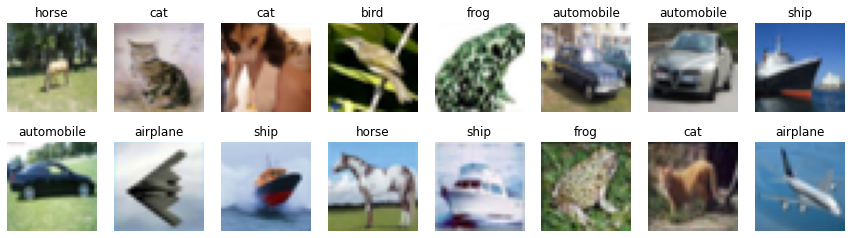

In [7]:
cols=8
rows=2
fig=plt.figure(figsize=(2*cols-1,2.5*rows-1))
for i in range(cols):
  for j in range(rows):
    random_index=np.random.randint(0,x_train.shape[0])
    ax=fig.add_subplot(rows,cols,i*rows+j+1)
    ax.grid('off')
    ax.axis('off')
    ax.imshow(x_train[random_index,:])
    ax.set_title(cifar10_classes[y_train[random_index,0]])
plt.show()

In [0]:
x_train2=(x_train/255.)-0.5
x_test2=(x_test/255)-0.5
y_train2=keras.utils.to_categorical(y_train,num_classes=NUM_CLASSES)
y_test2=keras.utils.to_categorical(y_test,num_classes=NUM_CLASSES)

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,\
Activation,Dropout
from keras.layers.advanced_activations import LeakyReLU

In [0]:
def make_model():
  model=Sequential()
  model.add(Conv2D(16,(3,3),padding='same',strides=1,
                   input_shape=(32,32,3)))
  model.add(LeakyReLU(0.1))
  model.add(Conv2D(32,(3,3),padding='same',strides=1))
  model.add(LeakyReLU(0.1))

  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(32,(3,3),padding='same',strides=1,
                   input_shape=(None,32,32,3)))
  model.add(LeakyReLU(0.1))
  model.add(Conv2D(64,(3,3),padding='same',strides=1))
  model.add(LeakyReLU(0.1))

  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256))
  model.add(LeakyReLU(0.1))

  model.add(Dropout(0.5))

  model.add(Dense(10,activation='softmax'))

  return model

In [15]:
s=reset_tf_session()
model=make_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)      

In [0]:
INIT_LR=5e-3
BATCH_SIZE=32
EPOCHS=10

s=reset_tf_session()

model=make_model()

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adamax(lr=INIT_LR),
    metrics=['accuracy']
)

def lr_scheduler(epoch):
  return INIT_LR*0.9**epoch

class LrHistory(keras.callbacks.Callback):
  def on_epoch_begin(self,epoch,logs={}):
    print('Learning rate:',K.get_value(model.optimizer.lr))

In [17]:
model_filename='cifar.{0:03d}.hdfs'
last_finished_epoch=None

'''
from keras.models import load_model
s=reset_tf_session()
last_finished_epoch=7
model=load_model(model_filename.format(last_finished_epoch))
'''

'\nfrom keras.models import load_model\ns=reset_tf_session()\nlast_finished_epoch=7\nmodel=load_model(model_filename.format(last_finished_epoch))\n'

In [0]:
from collections import defaultdict
import tqdm

class TqdmProgressCallback(keras.callbacks.Callback):
  def on_train_begin(self,logs=None):
    self.epochs=self.params['epochs']

  def on_epoch_begin(self,epoch,logs=None):
    print('\nEpoch %d/%d'%(epoch+1,self.epochs))
    if 'steps' in self.params:
      self.use_steps=True
      self.target=self.params['steps']
    else:
      self.use_steps=False
      self.target=self.params['samples']
    self.prog_bar=tqdm.notebook.tqdm(total=self.target)
    self.log_values_by_metric=defaultdict(list)
  
  def _set_prog_bar_desc(self,logs):
    for k in self.params['metrics']:
      if k in logs:
        self.log_values_by_metric[k].append(logs[k])
    desc=';'.join('{0}: {1:.4f}'.format(k,np.mean(values)) \
    for k,values in self.log_values_by_metric.items())
    if hasattr(self.prog_bar,'set_description_str'):
      self.prog_bar.set_description_str(desc)
    else:
      self.prog_bar.set_description(desc)

  def on_batch_end(self,batch,logs=None):
    logs=logs or {}
    if self.use_steps:
      self.prog_bar.update(1)
    else:
      batch_size=log.get('size',0)
      self.prog_bar.update(batch_size)
    self._set_prog_bar_desc(logs)

  def on_epoch_end(self,epoch,logs=None):
    logs=logs or {}
    self._set_prog_bar_desc(logs)
    self.prog_bar.update(1)
    self.prog_bar.close()

In [0]:
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):

  def __init__(self,file_name):
    super(ModelSaveCallback,self).__init__()
    self.file_name=file_name

  def on_epoch_end(self,epoch,logs=None):
    model_filename=self.file_name.format(epoch)
    save_model(self.model,model_filename)
    print('Model saved in {}'.format(model_filename))

In [61]:
model.fit(
    x_train2,y_train2,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler),
               LrHistory(),
               TqdmProgressCallback(),
               ModelSaveCallback(model_filename)],
    validation_data=(x_test2,y_test2),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

Learning rate: 0.005

Epoch 1/10



Model saved in cifar.000.hdfs
Learning rate: 0.0045

Epoch 2/10



Model saved in cifar.001.hdfs
Learning rate: 0.00405

Epoch 3/10



Model saved in cifar.002.hdfs
Learning rate: 0.003645

Epoch 4/10



Model saved in cifar.003.hdfs
Learning rate: 0.0032805

Epoch 5/10



Model saved in cifar.004.hdfs
Learning rate: 0.00295245

Epoch 6/10



Model saved in cifar.005.hdfs
Learning rate: 0.002657205

Epoch 7/10



Model saved in cifar.006.hdfs
Learning rate: 0.0023914846

Epoch 8/10



Model saved in cifar.007.hdfs
Learning rate: 0.002152336

Epoch 9/10



Model saved in cifar.008.hdfs
Learning rate: 0.0019371024

Epoch 10/10



Model saved in cifar.009.hdfs


In [0]:
model.save_weights('weights.h5')

In [0]:
model.load_weights('weights.h5')

In [0]:
y_pred_test=model.predict_proba(x_test2)
y_pred_test_classes=np.argmax(y_pred_test,axis=1)
y_pred_test_max_probas=np.max(y_pred_test,axis=1)

No handles with labels found to put in legend.


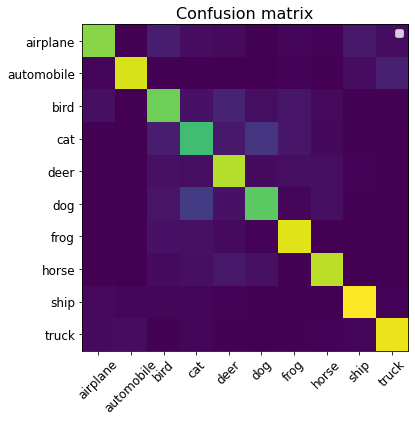

Test accuracy: 0.7926


In [67]:
from sklearn.metrics import confusion_matrix,accuracy_score
plt.figure(figsize=(7,6))
plt.title('Confusion matrix',fontsize=16)
plt.imshow(confusion_matrix(y_test,y_pred_test_classes))
plt.xticks(np.arange(10),cifar10_classes,rotation=45,fontsize=12)
plt.yticks(np.arange(10),cifar10_classes,fontsize=12)
plt.show()
print('Test accuracy:',accuracy_score(y_test,y_pred_test_classes))

In [0]:
s=reset_tf_session()
K.set_learning_phase(0)
model=make_model()
model.load_weights('weights.h5')

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)       

In [0]:
def find_maximum_stimuli(layer_name,is_conv,filter_index,model,
                         iterations=20,step=1.,verbose=True):
  def image_values_to_rgb(x):
    x_norm=(x-np.mean(x))*(0.25/np.std(x))
    x=(x_norm+0.5)*255
    x=np.clip(x,0,255).astype('uint8')
    return x

  input_img=model.input
  img_width,img_height=input_img.shape.as_list()[1:3]

  layer_output=list(filter(lambda x:x.name==layer_name,
                           model.layers))[0].output
  if is_conv:
    loss=K.mean(layer_output[:,:,:,filter_index])
  else:
    loss=K.mean(layer_output[:,filter_index])

  grads=K.gradients(loss,input_img)[0]
  grads=grads/(K.sqrt(K.sum(K.square(grads)))+1e-10)

  iterate=K.function([input_img],[loss,grads])

  input_img_data=np.random.random((1,img_width,img_height,3))
  input_img_data=(input_img_data-0.5)*(0.1 if is_conv else 0.001)
  
  for i in range(iterations):
    loss_value,grads_value=iterate([input_img_data])
    input_img_data+=grads_value*step
    if verbose:
      print('Current loss value:',loss_value)

  img=image_values_to_rgb(input_img_data[0])
  return img,loss_value

In [0]:
def plot_filters_stimuli(layer_name,is_conv,model,iterations=20,
                         step=1,verbose=False):
  cols=8
  rows=2
  filter_index=0
  max_filter_index=list(filter(lambda x:x.name==layer_name,
                               model.layers))[0].output.shape.as_list()[-1]-1
  fig=plt.figure(figsize=(2*cols-1,3*rows-1))
  for i in range(cols):
    for j in range(rows):
      if filter_index<=max_filter_index:
        ax=fig.add_subplot(rows,cols,i*rows+j+1)
        ax.grid('off')
        ax.axis('off')
        loss=-1e20
        while loss<0 and filter_index<=max_filter_index:
          stimuli,loss=find_maximum_stimuli(layer_name,is_conv,
                                            filter_index,model,
                                            iterations,step,verbose)
          filter_index+=1
        if loss>0:
          ax.imshow(stimuli)
          ax.set_title('Filter #{}'.format(filter_index))
    plt.show()

conv2d_1


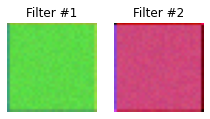

conv2d_2


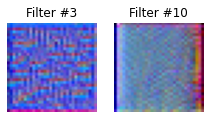

conv2d_3


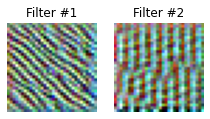

conv2d_4


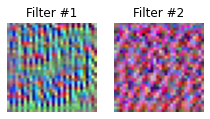

In [92]:
conv_activation_layers=[]
for layer in model.layers:
  # if isinstance(layer,LeakyReLU):
  #   prev_layer=layer.inbound_nodes[0].inbound_layers[0]
  if isinstance(layer,Conv2D):
    conv_activation_layers.append(layer)

for layer in conv_activation_layers:
  print(layer.name)
  plot_filters_stimuli(layer_name=layer.name,is_conv=True,model=model)

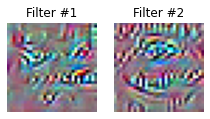

In [93]:
last_dense_layer=list(filter(lambda x: isinstance(x,Dense),
                             model.layers))[-1]
plot_filters_stimuli(layer_name=last_dense_layer.name,is_conv=False,
                     iterations=200,step=0.1,model=model)

In [0]:
#%load_ext tensorboard

In [0]:
#%tensorboard --logdir tmp/tboard